In [1]:
# Setup of libraries, mounting the Google Drive etc.

import os
import sys
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/Colab Notebooks')

import numpy as np
import tensorflow as tf

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [3]:
text = open(path).read()

# The length of text is the number of characters in it
print('Length of the text: {} characters'.format(len(text)))

Length of the text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))
# Length of the vocabulary of chars
vocab_size = len(vocab)

print('{} unique characters'.format(vocab_size))

65 unique characters


In [0]:
# Creating a mapping from unique characters to indices
char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = np.array(vocab)

In [7]:
print('{')
for char, _ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [8]:
# Show how the first 13 characters from the text mapped to integers
print('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), [char2idx[c] for c in text[:13]]))

'First Citizen' ---- characters mapped to int ---- > [18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52]


In [0]:
text = np.array(list(text))

In [10]:
print(text.shape)

(1115394,)


In [11]:
print(text)

['F' 'i' 'r' ... 'g' '.' '\n']


In [0]:
BATCH_SIZE = 64
SEQ_LENGTH = 100

n_batches = (text.shape[0] - 1) // (BATCH_SIZE * SEQ_LENGTH)
rounded_length = n_batches * BATCH_SIZE * SEQ_LENGTH

X = text[:rounded_length].reshape([BATCH_SIZE, n_batches * SEQ_LENGTH])
y = text[1:rounded_length + 1].reshape([BATCH_SIZE, n_batches * SEQ_LENGTH])

In [13]:
print(X.shape)

(64, 17400)


In [14]:
print(X)

[['F' 'i' 'r' ... 's' 'a' 'w']
 [' ' 'h' 'i' ... 'a' 'r' 'n']
 [' ' 'h' 'o' ... 'd' ',' ' ']
 ...
 ['v' 'i' 'l' ... 'h' 'y' ' ']
 ['s' 'o' 'v' ... 'o' 'u' ' ']
 ['r' 'e' 'p' ... 't' '\n' 'n']]


In [15]:
print(X[0, :15], '...')

['F' 'i' 'r' 's' 't' ' ' 'C' 'i' 't' 'i' 'z' 'e' 'n' ':' '\n'] ...


In [16]:
print(X[1, :15], '...')

[' ' 'h' 'i' 'm' ' ' 'r' 'u' 'n' ' ' 'a' 'f' 't' 'e' 'r' ' '] ...


In [17]:
print(X[:, 0])

['F' ' ' ' ' 'd' 'n' ' ' 'i' 'i' 't' 'n' 'h' 'r' 'b' 'c' 'e' 't' ' ' 'k'
 'y' 'h' ' ' ' ' ' ' ' ' 'T' 'r' 'a' 'e' ';' ' ' ':' 'd' 'g' ' ' 'r' 'i'
 'd' 'Y' 'C' 's' ' ' 'o' ' ' 'm' 'd' 't' ' ' 'e' 'r' 'h' 'o' ' ' 't' 'n'
 'h' 'A' ' ' '\n' ' ' 'w' 'h' 'v' 's' 'r']


In [18]:
X[:, 0].shape

(64,)

In [19]:
print(X[:, :SEQ_LENGTH])

[['F' 'i' 'r' ... 'Y' 'o' 'u']
 [' ' 'h' 'i' ... ' ' 'a' 'n']
 [' ' 'h' 'o' ... '?' '\n' '\n']
 ...
 ['v' 'i' 'l' ... 'w' 'i' 't']
 ['s' 'o' 'v' ... 't' 'h' ' ']
 ['r' 'e' 'p' ... 't' 'h' 'y']]


In [20]:
print(X[:, :SEQ_LENGTH].shape)

(64, 100)


In [21]:
print(X[:, SEQ_LENGTH:2 * SEQ_LENGTH])

[[' ' 'a' 'r' ... 'y' 'o' 'u']
 ['d' ' ' 'o' ... 'w' 'a' 's']
 ['A' 'U' 'F' ... 'r' 'd' ' ']
 ...
 ['n' 'e' 's' ... ' ' 'a' 'n']
 ['b' 'y' ' ' ... 'e' 'c' 'u']
 [' ' 'a' 'n' ... 't' ' ' 'm']]


In [22]:
print(X[:, SEQ_LENGTH:2 * SEQ_LENGTH].shape)

(64, 100)


In [0]:
def reshape_to_feed_order(data):
    tmp = data[:, :SEQ_LENGTH]
    for b in range(1, n_batches):
        tmp = np.concatenate([tmp, data[:, b * SEQ_LENGTH:(b + 1) * SEQ_LENGTH]])
    data = tmp
    del tmp
    
    return data

X = reshape_to_feed_order(X)
y = reshape_to_feed_order(y)

In [24]:
print(X.shape)

(11136, 100)


In [25]:
print(X)

[['F' 'i' 'r' ... 'Y' 'o' 'u']
 [' ' 'h' 'i' ... ' ' 'a' 'n']
 [' ' 'h' 'o' ... '?' '\n' '\n']
 ...
 [' ' 'd' 'e' ... 'h' 'y' ' ']
 ['u' 'e' '-' ... 'o' 'u' ' ']
 ['t' '.' '\n' ... 't' '\n' 'n']]


In [26]:
# If correctly shaped, these should NOT be in correct succession
print(X[0])
print(X[1])

['F' 'i' 'r' 's' 't' ' ' 'C' 'i' 't' 'i' 'z' 'e' 'n' ':' '\n' 'B' 'e' 'f'
 'o' 'r' 'e' ' ' 'w' 'e' ' ' 'p' 'r' 'o' 'c' 'e' 'e' 'd' ' ' 'a' 'n' 'y'
 ' ' 'f' 'u' 'r' 't' 'h' 'e' 'r' ',' ' ' 'h' 'e' 'a' 'r' ' ' 'm' 'e' ' '
 's' 'p' 'e' 'a' 'k' '.' '\n' '\n' 'A' 'l' 'l' ':' '\n' 'S' 'p' 'e' 'a'
 'k' ',' ' ' 's' 'p' 'e' 'a' 'k' '.' '\n' '\n' 'F' 'i' 'r' 's' 't' ' ' 'C'
 'i' 't' 'i' 'z' 'e' 'n' ':' '\n' 'Y' 'o' 'u']
[' ' 'h' 'i' 'm' ' ' 'r' 'u' 'n' ' ' 'a' 'f' 't' 'e' 'r' ' ' 'a' ' ' 'g'
 'i' 'l' 'd' 'e' 'd' '\n' 'b' 'u' 't' 't' 'e' 'r' 'f' 'l' 'y' ':' ' ' 'a'
 'n' 'd' ' ' 'w' 'h' 'e' 'n' ' ' 'h' 'e' ' ' 'c' 'a' 'u' 'g' 'h' 't' ' '
 'i' 't' ',' ' ' 'h' 'e' ' ' 'l' 'e' 't' ' ' 'i' 't' ' ' 'g' 'o' '\n' 'a'
 'g' 'a' 'i' 'n' ';' ' ' 'a' 'n' 'd' ' ' 'a' 'f' 't' 'e' 'r' ' ' 'i' 't'
 ' ' 'a' 'g' 'a' 'i' 'n' ';' ' ' 'a' 'n']


In [27]:
# If correctly shaped, these should be in correct succesion
print(X[0])
print(X[BATCH_SIZE])

['F' 'i' 'r' 's' 't' ' ' 'C' 'i' 't' 'i' 'z' 'e' 'n' ':' '\n' 'B' 'e' 'f'
 'o' 'r' 'e' ' ' 'w' 'e' ' ' 'p' 'r' 'o' 'c' 'e' 'e' 'd' ' ' 'a' 'n' 'y'
 ' ' 'f' 'u' 'r' 't' 'h' 'e' 'r' ',' ' ' 'h' 'e' 'a' 'r' ' ' 'm' 'e' ' '
 's' 'p' 'e' 'a' 'k' '.' '\n' '\n' 'A' 'l' 'l' ':' '\n' 'S' 'p' 'e' 'a'
 'k' ',' ' ' 's' 'p' 'e' 'a' 'k' '.' '\n' '\n' 'F' 'i' 'r' 's' 't' ' ' 'C'
 'i' 't' 'i' 'z' 'e' 'n' ':' '\n' 'Y' 'o' 'u']
[' ' 'a' 'r' 'e' ' ' 'a' 'l' 'l' ' ' 'r' 'e' 's' 'o' 'l' 'v' 'e' 'd' ' '
 'r' 'a' 't' 'h' 'e' 'r' ' ' 't' 'o' ' ' 'd' 'i' 'e' ' ' 't' 'h' 'a' 'n'
 ' ' 't' 'o' ' ' 'f' 'a' 'm' 'i' 's' 'h' '?' '\n' '\n' 'A' 'l' 'l' ':'
 '\n' 'R' 'e' 's' 'o' 'l' 'v' 'e' 'd' '.' ' ' 'r' 'e' 's' 'o' 'l' 'v' 'e'
 'd' '.' '\n' '\n' 'F' 'i' 'r' 's' 't' ' ' 'C' 'i' 't' 'i' 'z' 'e' 'n' ':'
 '\n' 'F' 'i' 'r' 's' 't' ',' ' ' 'y' 'o' 'u']


In [28]:
print(X.shape, y.shape)

(11136, 100) (11136, 100)


In [29]:
print(X[0, :15])
print(y[0, :15])

['F' 'i' 'r' 's' 't' ' ' 'C' 'i' 't' 'i' 'z' 'e' 'n' ':' '\n']
['i' 'r' 's' 't' ' ' 'C' 'i' 't' 'i' 'z' 'e' 'n' ':' '\n' 'B']


In [30]:
print(X[25, :15])
print(y[25, :15])

['r' ',' ' ' 'd' 'i' 'd' ' ' 'h' 'e' ' ' 'n' 'o' 't' '?' '\n']
[',' ' ' 'd' 'i' 'd' ' ' 'h' 'e' ' ' 'n' 'o' 't' '?' '\n' '\n']


In [0]:
def translate(text):
    one_hot =[]
    for seq in text:
        idx_seq = []
        for c in seq:
            idx_seq.append(char2idx[c])
        t_seq = tf.keras.utils.to_categorical(idx_seq, num_classes=vocab_size)
        one_hot.append(t_seq)
    
    return np.array(one_hot)

X = translate(X)
y = translate(y)

In [32]:
print(X.shape)
print(y.shape)

(11136, 100, 65)
(11136, 100, 65)


In [33]:
print(X)
print(y)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0. 0. 0

In [34]:
n_train = int(n_batches * 0.8) * BATCH_SIZE
X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:]
y_val = y[n_train:]

print('Train:', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)

Train: (8896, 100, 65) (8896, 100, 65)
Validation: (2240, 100, 65) (2240, 100, 65)


In [0]:
def build_model(vocab_size, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(1024, return_sequences=True, stateful=True, input_shape=(None, vocab_size), batch_size=batch_size),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))
    ])
    return model

In [0]:
model = build_model(vocab_size=vocab_size, batch_size=BATCH_SIZE)

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (64, None, 1024)          3348480   
_________________________________________________________________
time_distributed (TimeDistri (64, None, 65)            66625     
Total params: 3,415,105
Trainable params: 3,415,105
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.input

<tf.Tensor 'gru_input:0' shape=(64, ?, 65) dtype=float32>

In [39]:
# Test the shape of the output
test_batch = X[:BATCH_SIZE]
print('Input batch:', test_batch.shape)
test_predictions = model.predict(test_batch, batch_size=BATCH_SIZE)

print('Output batch:', test_predictions.shape)

model.reset_states()

Input batch: (64, 100, 65)
Output batch: (64, 100, 65)


In [40]:
sampled_indicies = np.argmax(test_predictions[0], axis=1)
sampled_indicies

array([37, 37, 16, 54,  8, 33, 33, 54, 33,  5,  5, 18,  6, 17, 55, 30, 18,
        4, 23, 23, 18, 33, 48, 48, 33, 33, 54, 26, 26, 18, 18, 18, 33, 27,
       62, 46, 33, 46, 20, 20,  0,  1,  6, 54, 16,  7,  1,  6, 34, 16,  0,
       33, 33, 33, 33, 33, 33, 29, 16,  4, 63, 63, 30, 36, 19, 34, 63,  6,
       13, 18, 29, 16, 16, 33, 33, 33, 33, 27, 16,  4, 63, 63, 37, 37, 16,
       54,  8, 33, 33, 54, 33,  5,  5, 18,  6, 17, 55, 58, 30, 64])

In [0]:
sampled_test_batch = np.argmax(test_batch[0], axis=1)

In [42]:
print('Input: \n', repr(''.join([idx2char[i] for i in sampled_test_batch])))
print()
print('Next Char Predictions: \n', repr(''.join([idx2char[i] for i in sampled_indicies])))

Input: 
 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

Next Char Predictions: 
 "YYDp.UUpU''F,EqRF&KKFUjjUUpNNFFFUOxhUhHH\n ,pD- ,VD\nUUUUUUQD&yyRXGVy,AFQDDUUUUOD&yyYYDp.UUpU''F,EqtRz"


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = 'training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "new_ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix)

In [46]:
history = model.fit(X_train, y_train, epochs=20, batch_size=BATCH_SIZE, shuffle=False, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Train on 8896 samples, validate on 2240 samples
Epoch 1/20
8896/8896 [==============================] - 58s 7ms/step - loss: 2.5052 - val_loss: 2.2379
Epoch 2/20
8896/8896 [==============================] - 58s 6ms/step - loss: 2.1311 - val_loss: 2.0367
Epoch 3/20
8896/8896 [==============================] - 58s 6ms/step - loss: 1.9537 - val_loss: 1.8936
Epoch 4/20
8896/8896 [==============================] - 57s 6ms/step - loss: 1.8162 - val_loss: 1.7734
Epoch 5/20
8896/8896 [==============================] - 57s 6ms/step - loss: 1.7056 - val_loss: 1.6790
Epoch 6/20
8896/8896 [==============================] - 58s 6ms/step - loss: 1.6170 - val_loss: 1.6068
Epoch 7/20
8896/8896 [==============================] - 58s 6ms/step - loss: 1.5435 - val_loss: 1.5532
Epoch 8/20
8896/8896 [==============================] - 57s 6ms/step - loss: 1.4816 - val_loss: 1.5105
Epoch 9/20
8896/8896 [==============================] - 57s 6ms/step - loss: 1.4305 - val_loss: 1.4807
Epoch 10/20
8896/8896 [==

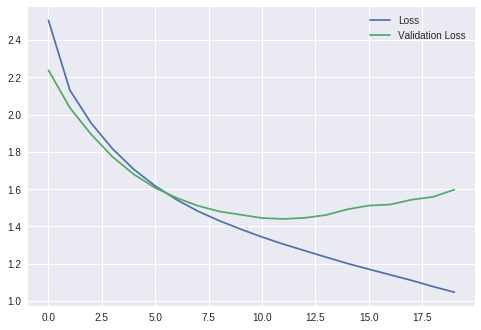

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [0]:
loaded_model = tf.keras.models.load_model('training_checkpoints/new_ckpt_20')

In [0]:
model = build_model(vocab_size, batch_size=1)

weights = loaded_model.get_weights()
model.set_weights(weights)

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, None, 1024)           3348480   
_________________________________________________________________
time_distributed_1 (TimeDist (1, None, 65)             66625     
Total params: 3,415,105
Trainable params: 3,415,105
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Generate text using the trained model

n_generate = 1000
start = 'R'
generated_text = [start]

model.reset_states()

for i in range(n_generate):
    input = generated_text[-1]
    input = char2idx[input]
    input = tf.keras.utils.to_categorical(input, num_classes=vocab_size)
    input = np.array([[input]])
    
    prediction = model.predict(input, batch_size=1)
    
    prediction = np.squeeze(prediction)
    prediction = np.argmax(prediction)
    prediction = idx2char[prediction]
    
    generated_text.append(prediction)

print(''.join(generated_text))

RI Clarence, to stay the sea
Where of the trick that we have slain:
And therefore let the life of the world.

Will he comes, they shall be secord on
the prison, call the from the light.

KING EDWARD IV:
Now, brother of his love did so yourself
That we are surernts to the ground, the sea
Whereoo me not, not the more of the world:
I would have left them to his son of heaven,
I will not be the sen the sea
What 'tis the man of my the business,
And set the frowns of me and my and see,
And let the self ame not to be conceated
In this beard all the beard of heaven,
Who is the sen the sea or war, I trust
Mest in the mind that have mine
To most and unnatural town,
And see hom I am nothing of the faire.

HENRY BOLINGBROKE:
Harry of Hereford, and the sea
Where of his shame, all ships of means,
Thy braved shall be of any of the world:
I would speak with the selfsame name,
In this shall smile at him.

First Keeper:
Ay, and the sen the duke we are to die.

ESCALUS:
Well, sir, the king where old man 